In [1]:
from dgd.utils.utils5 import *
import json, itertools, shutil, subprocess, re
from pathlib import Path
import os, re, subprocess, shutil, itertools
from pathlib import Path
import networkx as nx
from dgd.utils.verification import *

In [2]:
import pickle, time
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict
from tqdm.notebook import tqdm   
import numpy as np        

from dgd.environments.drl3env_loader4 import _apply_implicit_or, _compute_hash, _compute_truth_key

from dgd.utils.utils5 import (
    calculate_truth_table_v2,
    generate_one_hot_features_from_adj,
    resize_matrix,
    energy_score,
    check_implicit_OR_existence_v3,
    add_implicit_OR_to_dag_v2,
    exhaustive_cut_enumeration_dag,
    is_fanout_free_standalone,
    generate_subgraph,
    simulate_signal_propagation_binary,
    plot_circuit_layered
)

def load_registry(pkl_file):
    """Load the pickle and rebuild NetworkX graphs."""
    with open(pkl_file, "rb") as f:
        saved = pickle.load(f)

    registry = {}
    for h, bucket in saved.items():
        restored = []
        for canon_nl, orig_nl, e in bucket:
            canon = nx.node_link_graph(canon_nl)
            orig  = nx.node_link_graph(orig_nl)
            restored.append((canon, orig, e))
        registry[h] = restored
    return registry

def registry_size(reg):
    #reg = load_registry(pkl_file)
    length = sum(len(b) for b in reg.values())
    print(f"Registry length: {length}")
    return length

def fast_registry_size(pkl_file):
    """Fast-path: load the pickle and count (canon, orig, e) triples
       without rebuilding NetworkX graphs."""
    with open(pkl_file, "rb") as f:
        saved = pickle.load(f)          

    # each bucket is a list of (canon_nl, orig_nl, e) tuples
    return sum(len(bucket) for bucket in saved.values())


def draw_pair(canon, orig, h, e, seed=42):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
    for ax, g, ttl in zip(axes, (canon, orig), ("canonical", "original")):
        pos = nx.spring_layout(g, seed=seed)
        nx.draw(g, pos, ax=ax, with_labels=True, node_size=100, font_size=7)
        ax.set_title(ttl)
    fig.suptitle(f"hash={h}   energy={e:.3f}", fontsize=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def top_lowest_energy_plots(reg, n=20, pause=0):
    """
    Show a ranked table and inline plots for the `n` lowest-energy entries.

    Parameters
    ----------
    pkl_file : str or Path
        Pickled registry file.
    n : int, optional (default 20)
        Number of graph pairs to display.
    pause : float, optional (default 0)
        Seconds to wait between figures.
    """
    #reg = load_registry(pkl_file)
    flat = [
        (e, h, canon, orig)
        for h, bucket in reg.items()
        for canon, orig, e in bucket
    ]
    flat.sort(key=lambda t: t[0])

    print(f"\nTop-{n} by lowest energy:\n")
    print(f"{'rank':>4} │ {'energy':>10} │ {'hash':<16} │ nodes")
    print("────┼────────────┼────────────────┼──────")
    for i, (e, h, canon, orig) in enumerate(flat[:n], 1):
        print(f"{i:>4} │ {e:10.4f} │ {h:<16} │ {orig.number_of_nodes():>5}")
        draw_pair(canon, orig, h, e)
        if pause:
            time.sleep(pause)

def iso_pairs_lowest(reg, top=20):
    """
    Among the `top` lowest-energy *canonical* graphs, print every pair that
    is isomorphic.  Returns a list of (i, j) index pairs.
    """
    #reg = load_registry(pkl_file)

    # flatten and keep canonical graph
    flat = [(e, h, canon)
            for h, bucket in reg.items()
            for canon, _, e in bucket]
    flat.sort(key=lambda t: t[0])
    flat = flat[:top]                       # lowest-energy slice

    duplicates = []
    for (i, (e_i, h_i, g_i)), (j, (e_j, h_j, g_j)) in itertools.combinations(enumerate(flat), 2):
        if nx.is_isomorphic(g_i, g_j):
            duplicates.append((i, j))
            print(f"Duplicate pair: idx {i} ↔ {j}   "
                  f"energies {e_i:.4f} / {e_j:.4f}   "
                  f"hashes {h_i} / {h_j}")

    if not duplicates:
        print(f"No canonical duplicates among the lowest {top} energies.")

    return duplicates


def remove_redundant_edges(g):
    """Return a copy of `g` with every non-essential edge pruned."""
    g = g.copy()
    tt_ref = calculate_truth_table_v2(g)
    changed = True
    while changed:
        changed = False
        for u, v in list(g.edges()):
            g_tmp = g.copy()
            g_tmp.remove_edge(u, v)
            if calculate_truth_table_v2(g_tmp) == tt_ref:
                g.remove_edge(u, v)
                changed = True
    return g

def unique_by_isomorphism(graphs):
    uniq = []
    for g in graphs:
        if not any(nx.is_isomorphic(g, h) for h in uniq):
            uniq.append(g)
    return uniq


def plot_graphs(graphs, cols=3, seed=42):
    rows = (len(graphs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.ravel()
    for ax, g in zip(axes, graphs):
        pos = nx.spring_layout(g, seed=seed)
        nx.draw(g, pos, ax=ax, with_labels=True, node_size=100, font_size=7)
        ax.set_title(f"nodes={g.number_of_nodes()}  edges={g.number_of_edges()}")
    for ax in axes[len(graphs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


def prune_and_plot_optimal(reg, verbose = True):
    """
    • keep every graph at the absolute minimum energy
    • remove redundant edges in each
    • drop isomorphic duplicates
    • plot & print truth tables
    • RETURN the list of unique pruned graphs
    """

    # -- keep only the optimal energy ----------------------------------------
    flat = [(e, canon) for bucket in reg.values() for canon, _, e in bucket]
    best_energy = min(e for e, _ in flat)
    best_graphs = [canon for e, canon in flat if e == best_energy]
    if verbose: print(f"Optimal energy: {best_energy:.4f}   raw count: {len(best_graphs)}")

    # -- prune redundant edges -----------------------------------------------
    pruned = [remove_redundant_edges(g) for g in best_graphs]

    # -- drop isomorphic duplicates ------------------------------------------
    unique = unique_by_isomorphism(pruned)
    if verbose: print(f"{len(unique)} unique graph(s) remain after pruning + iso check.\n")

    # -- plot each graph and print its truth table ---------------------------
    if verbose:
        for idx, g in enumerate(unique, 1):
            # plot
            plt.figure(figsize=(4, 4))
            pos = nx.spring_layout(g, seed=42)
            nx.draw(g, pos, with_labels=True, node_size=100, font_size=7)
            plt.title(f"Graph {idx}   nodes={g.number_of_nodes()}  edges={g.number_of_edges()}")
            plt.show()

            # truth table
            tt = calculate_truth_table_v2(g)
            print(f"Truth table for Graph {idx}:")
            for inputs, out in sorted(tt.items()):
                print(f"  {inputs}  →  {out[0]}")
            print()

    return unique

def prune_and_plot_optimal_v2(reg, verify_canon_transformation = True, verbose = True):
    """
    Same as prune_and_plot_optimal but also ensures the orginal and canon are trasformed correctly
    """

    # -- keep only the optimal energy ----------------------------------------
    flat = [(e, canon, orig)           # unpack the bucket
            for bucket in reg.values()
            for canon, orig, e in bucket]
    
    best_energy = min(e for e, _, _ in flat)
    
    best_pairs = [(canon, orig) for e, canon, orig in flat if e == best_energy]
    best_graphs = [canon for e, canon, orig in flat if e == best_energy]
    if verbose: print(f"Optimal energy: {best_energy:.4f}   raw count: {len(best_graphs)}")

    for canon, orig in best_pairs:
        if verify_canon_transformation:
            rebuilt_canon = _apply_implicit_or(orig)
            if not nx.is_isomorphic(rebuilt_canon, canon):
                print("Mismatch: stored canon ≠ _apply_implicit_or(orig)")
            else:
                if verbose: print("Stored canon = _apply_implicit_or(orig)")

    # -- prune redundant edges -----------------------------------------------
    pruned = [remove_redundant_edges(g.copy()) for g in best_graphs]

    # -- drop isomorphic duplicates ------------------------------------------
    unique = unique_by_isomorphism(pruned)
    if verbose: print(f"{len(unique)} unique graph(s) remain after pruning + iso check.\n")

    # -- plot each graph and print its truth table ---------------------------
    if verbose:
        for idx, g in enumerate(unique, 1):
            # plot
            plt.figure(figsize=(4, 4))
            pos = nx.spring_layout(g, seed=42)
            nx.draw(g, pos, with_labels=True, node_size=100, font_size=7)
            plt.title(f"Graph {idx}   nodes={g.number_of_nodes()}  edges={g.number_of_edges()}")
            plt.show()

            # truth table
            tt = calculate_truth_table_v2(g)
            print(f"Truth table for Graph {idx}:")
            for inputs, out in sorted(tt.items()):
                print(f"  {inputs}  →  {out[0]}")
            print()

    return unique

def energies_from_log(txt_file):
    pat = re.compile(r"^\s*(?:\Selected)\s+(.*_NIG_unoptimized\.pkl)$")
    paths = [m.group(1).strip() for line in open(txt_file)
             if (m := pat.match(line))]
    if not paths:
        print("No circuit paths found in the file."); return

    rows = []
    for fp in tqdm(paths, desc="Processing circuits", unit="circuit"):
        G = load_graph_pickle(fp)
        E_orig, _ = energy_score(G, check_implicit_OR_existence_v3)

        canon = _apply_implicit_or(G)
        E_canon, _ = energy_score(canon, check_implicit_OR_existence_v3)

        hex_id = Path(fp).name.split("_")[0]
        rows.append((hex_id, E_orig, E_canon))

    df = pd.DataFrame(rows,
                      columns=["truth_table_hex",
                               "E_original",
                               "E_canonical"])

    # pretty print
    print(f"\nEnergy summary ({len(rows)} circuits):\n")
    print(f"{'hex':<6} │ {'orig':>8} │ {'canon':>8}")
    print("───────┼──────────┼──────────")
    for h, e1, e2 in rows:
        print(f"{h:<6} │ {e1:8.3f} │ {e2:8.3f}")
 
    return df       
        
        
def load_graph_pickle(filename):
    num_nodes, edges, node_attrs = pickle.load(open(filename, "rb"))
    G = nx.DiGraph()
    for n, attr in node_attrs.items():
        G.add_node(n, type=attr) if attr is not None else G.add_node(n)
    G.add_edges_from(edges)
    return G

# %%
MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]       
TTABLE_TO_ACTIONS = action_motifs["lookup"]

# %% [markdown]
# Validation of UNIQUE_GRAPHS and TTABLE_TO_ACTIONS

# %%
import itertools, networkx as nx
from tqdm.notebook import tqdm   # use the Jupyter-friendly tqdm variant


def _all_truth_keys_for_graph(g):
    """Return the set of keys produced by every permutation of g's inputs."""
    inputs = [n for n in g if g.in_degree(n) == 0]
    keys   = set()
    for perm in itertools.permutations(inputs):
        g_perm = nx.relabel_nodes(g, dict(zip(inputs, perm)), copy=True)
        keys.add(_compute_truth_key(g_perm))
    return keys

def validate_ttable_to_actions(motifs=UNIQUE_GRAPHS, lookup=TTABLE_TO_ACTIONS):
    """
    Rebuild a permutation-aware lookup from `motifs` and check that it is
    identical to `lookup`.  Prints a summary and returns True/False.
    """
    rebuilt = {}                      # key → set(action_ids)

    bar = tqdm(enumerate(motifs), total=len(motifs),
            desc="Building internal lookup", unit="motif")

    for idx, g in bar:
        for k in _all_truth_keys_for_graph(g):
            rebuilt.setdefault(k, set()).add(idx)

    # ---------- normalise the original lookup to the same {key:set} shape ---
    normalised = {k: set(ids) for k, ids in lookup.items()}

    # ---------- compare ------------------------------------------------------
    if rebuilt == normalised:
        print("TTABLE_TO_ACTIONS is permutation-aware and 100 % consistent.")
        return True

    # ---------- report differences ------------------------------------------
    missing   = rebuilt.keys()   - normalised.keys()
    extra     = normalised.keys() - rebuilt.keys()
    mismatch  = {k for k in rebuilt.keys() & normalised.keys()
                if rebuilt[k] != normalised[k]}

    print("VALIDATION FAILED")
    if missing:
        print(f"  • Keys missing from lookup: {len(missing)}")
    if extra:
        print(f"  • Extra keys in lookup: {len(extra)}")
    if mismatch:
        print(f"  • Keys with differing ID lists: {len(mismatch)}")

    return False

#validate_ttable_to_actions(UNIQUE_GRAPHS, TTABLE_TO_ACTIONS)

# %%
def build_motif_canonicals():
    """
    Compute canonical form for every motif in global UNIQUE_GRAPHS and
    store them in UNIQUE_GRAPHS_canonical, with a progress bar.
    """
    global UNIQUE_GRAPHS_canonical
    bar = tqdm(UNIQUE_GRAPHS, desc="Canonicalising motifs", unit="motif")
    UNIQUE_GRAPHS_canonical = [_apply_implicit_or(g.copy()) for g in bar]
    print(f"Built canonical bank for {len(UNIQUE_GRAPHS_canonical)} motifs.")
    
    
def build_motif_canonicals_pruned():
    """
    Canonicalise + prune every motif in the global UNIQUE_GRAPHS list and
    store the results in UNIQUE_GRAPHS_canonical_pruned.
    """
    global UNIQUE_GRAPHS_canonical_pruned

    bar = tqdm(UNIQUE_GRAPHS, desc="Canonicalising + pruning", unit="motif")
    UNIQUE_GRAPHS_canonical_pruned = [
        remove_redundant_edges(_apply_implicit_or(g).copy())  
        for g in bar
    ]
    print(f"Built *pruned* canonical bank for {len(UNIQUE_GRAPHS_canonical_pruned)} motifs.")
    

def check_vs_motif_bank(graphs):
    """
    For each graph in `graphs`, report whether it is isomorphic to any
    canonical motif.  Shows a progress bar over the input list.
    """
    if "UNIQUE_GRAPHS_canonical" not in globals():
        build_motif_canonicals()

    new_count = 0
    bar = tqdm(enumerate(graphs, 1), total=len(graphs), desc="Matching", unit="graph")
    for idx, g in bar:
        #canon_g = _apply_implicit_or(g)
        canon_g = g
        
        #match = any(nx.is_isomorphic(canon_g, m) for m in UNIQUE_GRAPHS_canonical)
        match = False                              # default: no match yet
        for m in UNIQUE_GRAPHS_canonical:          # scan every canonical motif
            if nx.is_isomorphic(canon_g, m):       # found an isomorphic partner?
                match = True                       # mark it
                break                              # stop checking further              
        
        status = "MATCH" if match else "NEW  "
        if not match:                            
            new_count += 1
        bar.set_postfix({"last": status})      # live status in the bar
        print(f"Graph {idx:>2}: {status}   "
            f"nodes={g.number_of_nodes():>2}  edges={g.number_of_edges():>2}")
    return new_count 

def check_vs_motif_bank_pruned(graphs):

    # Build the bank the first time this function is called
    if "UNIQUE_GRAPHS_canonical_pruned" not in globals():
        build_motif_canonicals_pruned()
        
    new_count = 0
    bar = tqdm(enumerate(graphs, 1), total=len(graphs), desc="Matching", unit="graph")
    for idx, g in bar:
        #canon_g = _apply_implicit_or(g)
        canon_g = g
        
        #match = any(nx.is_isomorphic(canon_g, m) for m in UNIQUE_GRAPHS_canonical)
        match = False                              # default: no match yet
        for m in UNIQUE_GRAPHS_canonical_pruned:   # scan every canonical motif
            if nx.is_isomorphic(canon_g, m):       # found an isomorphic partner?
                match = True                       # mark it
                break                              # stop checking further              
        
        status = "MATCH" if match else "NEW  "
        if not match:                           
            new_count += 1                
        bar.set_postfix({"last": status})      # live status in the bar
        print(f"Graph {idx:>2}: {status}   "
            f"nodes={g.number_of_nodes():>2}  edges={g.number_of_edges():>2}")
        
    return new_count  
def _format_truth_table(tt):
    rows = sorted(tt.items(), key=lambda kv: kv[0])
    lines = [f"  {inp}  →  {out}" for inp, out in rows]
    return "\n".join(lines)

def compare_to_motif_bank(unique_graphs, *,verbose = False, plotting = False, max_plots_per_key: int = 5):

    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    # confirm a single truth-table key ───────────────────────────
    ref_key = _compute_truth_key(unique_graphs[0])
    for i, g in enumerate(unique_graphs, 1):
        k = _compute_truth_key(g)
        if k != ref_key:
            raise ValueError(
                f"Graph #{i-1} has key {k}, but expected all to share {ref_key}"
            )

    # verbose: print candidate truth table once
    tt_candidate = calculate_truth_table_v2(unique_graphs[0])
    if verbose:        
        print(f"\nTruth table for CANDIDATE graphs (key {ref_key}):")
        print(_format_truth_table(tt_candidate), "\n")

    # locate real matches in the bank (permutation test) ─────────
    candidate_idxs = TTABLE_TO_ACTIONS.get(ref_key, [])
    
    print("candidate_idxs :" , candidate_idxs)
    
    matching_idxs  = []          # accepted motif indices
    bank_ttables   = {}          # idx → truth table of matching permutation

    for j in candidate_idxs:
        motif  = UNIQUE_GRAPHS[j]
        inputs = [n for n in motif if motif.in_degree(n) == 0]

        for perm in itertools.permutations(inputs):
            g_perm = nx.relabel_nodes(
                motif, dict(zip(inputs, perm)), copy=True
            )
            if calculate_truth_table_v2(g_perm) == tt_candidate:
                matching_idxs.append(j)
                bank_ttables[j] = calculate_truth_table_v2(g_perm)
                break   # first good permutation is enough

    if verbose:
        if matching_idxs:
            for j in matching_idxs:
                print(f"Truth table for BANK motif idx {j} (key {ref_key}):")
                print(_format_truth_table(bank_ttables[j]), "\n")
        else:
            print("No bank motif can realise this truth table.\n")

    # compute energies for accepted motifs only ──────────────────
    bank_energy_cache = {}
    best_bank_energy  = None
    if matching_idxs:
        best_bank_energy = float("inf")
        for j in matching_idxs:
            e = energy_score(UNIQUE_GRAPHS[j],
                            check_implicit_OR_existence_v3)[0]
            bank_energy_cache[j] = e
            best_bank_energy = min(best_bank_energy, e)

    # score each candidate graph ─────────────────────────────────
    results = []
    for idx, g in enumerate(
            tqdm(unique_graphs, desc="Scoring candidates", unit="graph")):
        own_e = energy_score(g, check_implicit_OR_existence_v3)[0]
        delta = None if best_bank_energy is None else own_e - best_bank_energy
        results.append(dict(
            idx=idx, key=ref_key,
            ML_energy=own_e,
            best_bank_energy=best_bank_energy,
            delta=delta,
        ))

    # optional plotting of motifs (stored vs canonical) ──────────
    if plotting and matching_idxs:
        for j in matching_idxs[:max_plots_per_key]:
            bank_g  = UNIQUE_GRAPHS[j]
            canon_g = _apply_implicit_or(bank_g)
            e_bank  = bank_energy_cache[j]

            fig, axes = plt.subplots(1, 2, figsize=(7, 3))
            fig.suptitle(f"Key {ref_key} | bank idx {j} | E = {e_bank:.2f}")

            axes[0].set_title("Stored motif")
            nx.draw(bank_g,  ax=axes[0], with_labels=True,
                    node_size=150, font_size=6)
            axes[0].axis("off")

            axes[1].set_title("Canonical form")
            nx.draw(canon_g, ax=axes[1], with_labels=True,
                    node_size=150, font_size=6)
            axes[1].axis("off")

            plt.tight_layout()
            plt.show()

    return results


def compare_to_motif_bank_simple(unique_graphs, *, verbose = False):

    # -- 0) Sanity checks -----------------------------------------------------
    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    ref_key = _compute_truth_key(unique_graphs[0])
    if any(_compute_truth_key(g) != ref_key for g in unique_graphs[1:]):
        raise ValueError("All graphs must share the same truth‑table key")

    # -- 1) Retrieve bank motifs known to implement this truth table ----------
    bank_idxs = TTABLE_TO_ACTIONS.get(ref_key, [])
    if verbose:
        print(f"Truth‑table key: {ref_key}\nBank motif indices: {bank_idxs}\n")

    # -- 2) Compute energies --------------------------------------------------
    bank_energies: Dict[int, float] = {
        j: energy_score(UNIQUE_GRAPHS[j], check_implicit_OR_existence_v3)[0]
        for j in bank_idxs
    }
    best_bank_energy = min(bank_energies.values()) if bank_energies else None

    candidate_energies = [
        energy_score(g, check_implicit_OR_existence_v3)[0] for g in unique_graphs
    ]

    # -- 3) Assemble *results* list ------------------------------------------
    results = []
    for idx, own_e in enumerate(candidate_energies):
        delta = None if best_bank_energy is None else own_e - best_bank_energy
        results.append(
            dict(
                idx=idx,
                key=ref_key,
                ML_energy=own_e,
                best_bank_energy=best_bank_energy,
                delta=delta,
            )
        )

    if verbose:
        print("Candidate energies:", candidate_energies)
        print("Bank energies     :", bank_energies)
        print("\nResults list:")
        for r in results:
            print(r)

    return results

def compare_to_motif_bank_perm(unique_graphs, *, verbose=False):

    # 0) basic sanity
    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    ref_key = _compute_truth_key(unique_graphs[0])
    if any(_compute_truth_key(g) != ref_key for g in unique_graphs[1:]):
        raise ValueError("All graphs must share the same truth-table key")

    # 1) build an internal lookup: key → set(motif IDs)
    bank_idxs = []
    for idx, motif in tqdm(enumerate(UNIQUE_GRAPHS),  total=len(UNIQUE_GRAPHS), desc="Scanning motif bank", unit="motif"):
        if ref_key in _all_truth_keys_for_graph(motif):
            bank_idxs.append(idx)

    if verbose:
        print(f"Truth-table key: {ref_key}\nBank motif indices: {bank_idxs}\n")

    # 2) compute energies
    bank_energies = {j: energy_score(UNIQUE_GRAPHS[j], check_implicit_OR_existence_v3)[0]  for j in bank_idxs}
    best_bank_energy = min(bank_energies.values()) if bank_energies else None

    candidate_energies = [energy_score(g, check_implicit_OR_existence_v3)[0] for g in unique_graphs]

    # 3) assemble results
    results = []
    for idx, own_e in enumerate(candidate_energies):
        delta = None if best_bank_energy is None else own_e - best_bank_energy
        results.append(
            dict(
                idx=idx,
                key=ref_key,
                ML_energy=own_e,
                best_bank_energy=best_bank_energy,
                delta=delta,
            )
        )

    if verbose:
        print("Candidate energies:", candidate_energies)
        print("Bank energies     :", bank_energies)
        print("\nResults list:")
        for r in results:
            print(r)

    return results

def verify_hex_consistency(
    sim_hex_all,
    tt_hex_all,
    initial_size_of_graph_hex,
    circuit_hex,
):

    if len(sim_hex_all) != len(tt_hex_all):
        raise ValueError(
            f"List-length mismatch: sim_hex_all has {len(sim_hex_all)} items, "
            f"tt_hex_all has {len(tt_hex_all)} items."
        )

    all_ok = True
    for idx, (sim_h, tt_h) in enumerate(zip(sim_hex_all, tt_hex_all)):
        if not (
            sim_h == tt_h
            == initial_size_of_graph_hex
            == circuit_hex
        ):
            print(
                f"[Mismatch @ index {idx}] "
                f"sim={sim_h}, tt={tt_h}, "
                f"initial={initial_size_of_graph_hex}, circuit={circuit_hex}"
            )
            all_ok = False

    if all_ok:
        print("All hex strings agree across lists and with both reference strings.")
        
        
# %% 
summary_rows = []

Done loading action motifs. There are 15928 unique motifs.


In [3]:
def truth_table_impl_user(G, input_names, output_names):
    G2 = G.copy()
    for o in output_names:
        G2.nodes[o]['type'] = 'output'
    return calculate_truth_table_v2(G2)

In [4]:
#file_name = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/notebooks/0x00BF_ML_topology_designs_reduced.pkl'

file_name = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_0x96F7_testing_drl3env_loader5/seed_1/optimal_topologies/optimal_topologies.pkl' 
with open(file_name, 'rb') as file:
    test_graphs = pickle.load(file)
test_graph = test_graphs[0]
G = test_graph

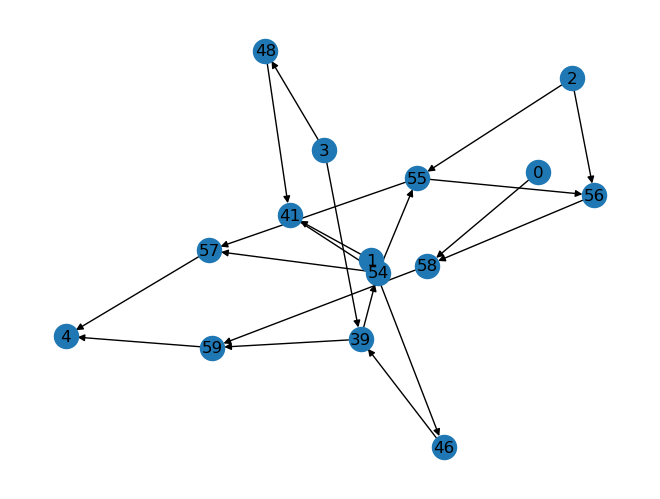

In [5]:
nx.draw(G, with_labels = True)

In [6]:
ARTIFACTS = Path("yosys_validation")
ARTIFACTS.mkdir(exist_ok=True)



In [7]:
plot_circuit_layered(
    G,
    outdir="circuit_plot",
    name="my_circuit_small",
    fmt="pdf",                   # or "svg"
    rankdir="LR",
    show_in_notebook=False,      # important: allows gv_size to apply
    compact=True,
    gv_size="6,4!",            # inches; "!" forces exact scaling
    gv_dpi=None,                 # do NOT set dpi for vector export
    gv_margin="0.05",
    gv_pad="0.05"
)


PosixPath('/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/tests/circuit_plot/my_circuit_small.pdf')

In [ ]:
file_name.split('_', 1)[0]

In [ ]:
ins, outs = infer_io(G)  # numeric order preserved
print("Inputs:", ins, "Outputs:", outs)

rows_gold = dict_tt_to_rows(calculate_truth_table_v2(G), ins, outs)   # from your function
_, rows_gate = truth_table_baseline(G, ins, outs)                      # from graph semantics
assert rows_gold == rows_gate, "Python-level mismatch."
print("Python-level check: Passed")

In [ ]:
ins, outs = infer_io(G)  
print("Inputs:", ins, "Outputs:", outs)

gate_v = write_gate_verilog(G, ins, outs, module="gate", folder=ARTIFACTS)
gold_v = write_gold_verilog(G, truth_table_impl_user, ins, outs, module="gold", folder=ARTIFACTS)
print("Wrote:", gate_v, gold_v)


In [ ]:
are_circuits_functionally_equivalent = run_equiv_check(folder=ARTIFACTS)

In [ ]:
are_tts_equivalent = validate_tt_using_yosys(G, folder=ARTIFACTS)

In [ ]:
combos, yosys_rows = yosys_truth_table_with_yosys(G)

In [ ]:
combos, yosys_rows = yosys_truth_table_with_yosys(
    folder=ARTIFACTS,
    top_module="gate",   # or "gold"
    input_names=ins,     # [input nodes]
    output_names=outs    # [output node]
)

In [ ]:
yosys_vs_python_truth_table(G, strict=True)

In [ ]:
calculate_truth_table_v2(test_graph)

In [ ]:
print((ARTIFACTS / "tt_0.txt").read_text())
print((ARTIFACTS / "tt_0.json").read_text())

In [ ]:
nx.draw(test_graph, with_labels=True)
for node in test_graph.nodes(data=True):
    print(node)

In [ ]:
tt = calculate_truth_table_v2(test_graph)
len(tt).bit_length()

Multiple Testing

In [ ]:
circuits_hex_list = [
"0x000D",
"0x0239",
"0xFC79"]

yosys_hex_all = []

for circuit_hex in circuits_hex_list:
    
    print(f"Circuit hex is {circuit_hex}")

    run_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_{circuit_hex}/seed_1"

    run_dir = Path(run_dir)

    rx = re.compile(r"shared_registry_([\d_]+)\.pkl$")

    def tag_value(p: Path) -> int:
        """Return the numeric tag, e.g. '4_800' -> 4800."""
        m = rx.fullmatch(p.name)
        if not m:
            raise ValueError(f"Not a registry file: {p}")
        return int(m.group(1).replace("_", ""))     # drop underscores, then int()

    try:
        latest = max(
            (p for p in run_dir.glob("shared_registry_*.pkl")),
            key=tag_value
        )
        print("Latest snapshot:", latest, "steps =", tag_value(latest))
        pkl_path = latest
    except ValueError:
        print("No shared_registry_*.pkl found in", run_dir)
        
    registry  = load_registry(pkl_path)

    unique_graphs = prune_and_plot_optimal_v2(registry)

    # 1) run both functions
    res1 = prune_and_plot_optimal(registry, verbose=False)          # list[DiGraph]
    res2 = prune_and_plot_optimal_v2(registry, verbose=False)       # list[DiGraph]

    # 2) quick sanity-check: same cardinality
    assert len(res1) == len(res2), "different number of graphs returned"

    # 3) make sure every graph in res1 has an isomorphic twin in res2
    for g in res1:
        if not any(nx.is_isomorphic(g, h) for h in res2):
            raise AssertionError("at least one graph in res1 is missing from res2")

    # 4) and vice-versa (optional if you know res2 can’t contain extras)
    for h in res2:
        if not any(nx.is_isomorphic(h, g) for g in res1):
            raise AssertionError("at least one graph in res2 is missing from res1")

    print("Prune_and_plot_optimal and prune_and_plot_optimal_v2 give the same set of graphs")


    number_of_smallest_ML_circuits = len(unique_graphs)
    number_NOT_iso_to_motifs = check_vs_motif_bank(unique_graphs)
    number_NOT_iso_to_motifs_after_pruning = check_vs_motif_bank_pruned(unique_graphs)


    # %%
    log_file = run_dir / "selected_graphs.txt" 
    energies_from_log_df = energies_from_log(str(log_file))
    
    initial_size_of_graph_hex =  energies_from_log_df.loc[0, 'truth_table_hex']
    initial_size_of_graph = energies_from_log_df.loc[0, 'E_original']

    # %%
    output_dir = run_dir / "optimal_topologies"
    output_dir.mkdir(parents=True, exist_ok=True)
    energies_from_log_df.to_csv(output_dir/"sizes_of_unoptimized_graphs_logged_in_selected_graphs.csv", index=False) 

    # %% [markdown]
    # Check the sizes of the motifs that can compute this logic function
    # %%
    comparison = compare_to_motif_bank(unique_graphs, verbose = True, max_plots_per_key = 10,plotting = True)

    pd.DataFrame(comparison).head()

    # %% [markdown]
    # Double-check the sizes of the motifs that can compute this logic function using an alternative methods

    # %%
    comparison2 = compare_to_motif_bank_simple(unique_graphs, verbose = True)

    comparison2_df = pd.DataFrame(comparison2)

    comparison2_df


    output_dir = run_dir / "optimal_topologies"
    output_dir.mkdir(parents=True, exist_ok=True)

    comparison2_df.to_csv(output_dir /"size_comparisons_to_action_motifs.csv", index=False)

    smallest_ML_size = comparison2_df.loc[0, 'ML_energy']
    smallest_precomputed_motif = comparison2_df.loc[0, 'best_bank_energy']

    # %%
    graph_to_check_inputs = unique_graphs[0]
    input_nodes = [node for node in graph_to_check_inputs.nodes() if graph_to_check_inputs.in_degree(node) == 0]
    num_inputs = len(input_nodes)
    print(f"Number of inputs is {num_inputs}")

    if num_inputs == 3:

        input_signals_list_binary = [
            {0: 0, 1: 0, 2: 0},  # First set of input signals
            {0: 0, 1: 0, 2: 1},  # Second set of input signals
            {0: 0, 1: 1, 2: 0},  # Third set of input signals
            {0: 0, 1: 1, 2: 1},  # First set of input signals
            {0: 1, 1: 0, 2: 0},  # Second set of input signals
            {0: 1, 1: 0, 2: 1},  # Third set of input signals    
            {0: 1, 1: 1, 2: 0},  # Second set of input signals
            {0: 1, 1: 1, 2: 1},  # Third set of input signals  
        ]   

    elif num_inputs == 4:
        input_signals_list_binary = [
            {0: 0, 1: 0, 2: 0, 3: 0},  
            {0: 0, 1: 0, 2: 0, 3: 1},  
            {0: 0, 1: 0, 2: 1, 3: 0}, 
            {0: 0, 1: 0, 2: 1, 3: 1}, 
            {0: 0, 1: 1, 2: 0, 3: 0},  
            {0: 0, 1: 1, 2: 0, 3: 1},    
            {0: 0, 1: 1, 2: 1, 3: 0},  
            {0: 0, 1: 1, 2: 1, 3: 1}, 
            {0: 1, 1: 0, 2: 0, 3: 0},  
            {0: 1, 1: 0, 2: 0, 3: 1},  
            {0: 1, 1: 0, 2: 1, 3: 0}, 
            {0: 1, 1: 0, 2: 1, 3: 1}, 
            {0: 1, 1: 1, 2: 0, 3: 0},  
            {0: 1, 1: 1, 2: 0, 3: 1},    
            {0: 1, 1: 1, 2: 1, 3: 0},  
            {0: 1, 1: 1, 2: 1, 3: 1},     
    ]    

    sim_hex_all = []   # holds each sim_hex, in the same order as unique_graphs
    tt_hex_all  = []   # holds each tt_hex,  likewise

    for g_idx, G_current in enumerate(unique_graphs):
        # --- generate results ---------------------------------------------------
        sim_raw = simulate_signal_propagation_binary(G_current, input_signals_list_binary)
        tt_raw  = calculate_truth_table_v2(G_current)

        # --- flatten outputs, preserving original order -------------------------
        sim_outputs = [list(d.values())[0] for d in sim_raw]       # [{4: 0}, …] → [0, …]
        tt_outputs  = [v[0]              for v in tt_raw.values()] # {…:(0,), …} → [0, …]

        # --- basic length check -------------------------------------------------
        if len(sim_outputs) != len(tt_outputs):
            raise ValueError(
                f"Length mismatch: {len(sim_outputs)} simulation cases "
                f"vs {len(tt_outputs)} truth-table cases."
            )

        # --- bit-string → padded → hex (keeping leading zeros) ------------------
        sim_bits = ''.join(str(b) for b in sim_outputs)
        tt_bits  = ''.join(str(b) for b in tt_outputs)

        sim_bits_padded = sim_bits.zfill((len(sim_bits) + 3) // 4 * 4)
        tt_bits_padded  = tt_bits .zfill((len(tt_bits ) + 3) // 4 * 4)

        sim_hex_digits = len(sim_bits_padded) // 4
        tt_hex_digits  = len(tt_bits_padded) // 4

        sim_hex = '0x' + format(int(sim_bits_padded, 2), f'0{sim_hex_digits}X')
        tt_hex  = '0x' + format(int(tt_bits_padded , 2), f'0{tt_hex_digits}X')


        sim_hex_all.append(sim_hex)
        tt_hex_all.append(tt_hex)

        print(f"\nGraph {G_current}:")
        print(f"  Simulation outputs (hex):    {sim_hex}")
        print(f"  Truth-table outputs (hex):   {tt_hex}")
        
        # --- Yosys vs Python truth table ----------------------------------------
        eq_folder = run_dir / "yosys_eqv" / f"graph_{g_idx:03d}"
        res_eq = yosys_vs_python_truth_table(G_current, folder=eq_folder, module="gate", strict=False)

        yosys_hex_all.append(res_eq["yosys_hex"])
        if res_eq["yosys_hex"] is not None:
            print(f"  Yosys TT (hex):              {res_eq['yosys_hex']}")

        if not res_eq["equal"]:
            for i, bits, y_row, p_row in res_eq["mismatches"][:10]:
                print(f"  mismatch row {i}, inputs {dict(zip(res_eq['inputs'], bits))}: "
                    f"Yosys={y_row}, Python={p_row}")
        else:
            print("  Yosys ↔ Python truth tables match.")
        

        # --- compare and report mismatches --------------------------------------
        all_match = True
        n_inputs  = len(next(iter(tt_raw)))        # number of input lines

        for idx, (s, t) in enumerate(zip(sim_outputs, tt_outputs)):
            if s != t:
                input_bits = tuple(int(b) for b in f"{idx:0{n_inputs}b}")
                print(f"  Input {input_bits}: simulation={s}, truth_table={t}")
                all_match = False

        if all_match:
            print("  Output patterns match.")
        else:
            print("  Finished comparison — mismatches listed above.")

    # %%
    '''
    #Save the graphs
    output_dir = run_dir / "optimal_topologies"
    output_dir.mkdir(parents=True, exist_ok=True)

    with open(output_dir / "optimal_topologies.pkl", "wb") as f:
        pickle.dump(unique_graphs, f)
    '''

    verify_hex_consistency(
        sim_hex_all,
        tt_hex_all,
        initial_size_of_graph_hex,
        circuit_hex,
    )
    
    hex_rows = []
    for idx, (sim_h, tt_h) in enumerate(zip(sim_hex_all, tt_hex_all)):
        hex_rows.append({
            "circuit_hex": circuit_hex,
            "graph_index": idx,
            "sim_hex": sim_h,
            "tt_hex": tt_h,
            "eq_sim_tt": (sim_h == tt_h),
            "eq_sim_initial": (sim_h == initial_size_of_graph_hex),
            "eq_tt_initial": (tt_h == initial_size_of_graph_hex),
            "eq_sim_circuit": (sim_h == circuit_hex),
            "eq_tt_circuit": (tt_h == circuit_hex),
            "all_equal": (sim_h == tt_h == initial_size_of_graph_hex == circuit_hex),
        })

    hex_df = pd.DataFrame(hex_rows)
    hex_csv = output_dir / f"verify_hex_consistency_{circuit_hex}.csv"
    hex_df.to_csv(hex_csv, index=False)
    print(f"Saved verify_hex_consistency results to {hex_csv}")

    # quick counters you can reuse in the summary row
    _verify_all_ok = bool(hex_df["all_equal"].all())
    _verify_num_mismatches = int((~hex_df["all_equal"]).sum())   
    
    
    
    print("----------------------------------------------------------------------")
    print("Summary: ")
    print(f"Initial graph hex:                      {initial_size_of_graph_hex}")
    print(f"Initial graph size decimal:             {initial_size_of_graph}")


    print(f"number_of_smallest_ML_circuits:         {number_of_smallest_ML_circuits}")
    print(f"Non-isomorphic to motifs:               {number_NOT_iso_to_motifs}")
    print(f"Non-isomorphic to motifs after pruning: {number_NOT_iso_to_motifs_after_pruning}")

    print(f"Smallest ML size found:                 {smallest_ML_size}")
    print(f"Smallest pre-computed motif size:       {smallest_precomputed_motif}")
    print("----------------------------------------------------------------------")
    
    summary_rows.append({
        "circuit_hex": circuit_hex,
        "initial_size_of_graph_hex": initial_size_of_graph_hex,
        "initial_size_of_graph": initial_size_of_graph,
        "number_of_smallest_ML_circuits": number_of_smallest_ML_circuits,        
        "number_NOT_iso_to_motifs": number_NOT_iso_to_motifs,
        "number_NOT_iso_to_motifs_after_pruning": number_NOT_iso_to_motifs_after_pruning,
        "smallest_ML_size": smallest_ML_size,
        "smallest_precomputed_motif": smallest_precomputed_motif,
        "verify_hex_all_equal": _verify_all_ok,
        "verify_hex_num_mismatches": _verify_num_mismatches,
    })    

'''
summary_df = pd.DataFrame(summary_rows)
out_csv = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs") / "Fig. 2 Sizes of random 4 input circuits plus hex verification (trained from scratch and automated analysis).csv"
summary_df.to_csv(out_csv, index=False)
print(f"Saved per-circuit summary to {out_csv}")
'''